In [1]:
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-notebook")

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from utils import get_dataset_from_pickle

import itertools

# City of Los Angeles: Proposing a Strategy for Optimizing Parking Enforcement Deployment

**Author: Evan Gabrielson**

---

A strategy for improving the efficiency of LADOT's Parking Enforcement division should function to save the city and citizenry of Los Angeles money. From public data published by the City of LA on their [Open Budget Explorer](https://openbudget.lacity.org/#!/year/2023/operating/0/department_name/Transportation/0/program_name/Parking+Enforcement+Services/0/source_fund_name), we can see that full and part-time salaries as well as overtime account for over 99% of allocated funding. While the official number of officers is not published publicly, we can use budget data and Indeed job postings by the City of LA to create a heuristic for the number of Full-Time Officers (FTO) working for the Parking Enforcement division.

$$\text{FTO Salary} = (\$23.00 \text{ per hour}) * (40 \text{ hours per week}) * (52 \text{ weeks per year}) =  \$47,840 \text{ annually}$$
$$\text{Number of FTOs} = \$58,311,479 \text{ budgeted for salaries } / \text{ } \$47,840 \text{ per FTO salary} = 1,218 \text{ FTOs}$$

In [6]:
fto_salary = 23 * 40 * 52
num_ftos = 58.3e6 // fto_salary
print(f"Number of FTOs: {num_ftos}")

Number of FTOs: 1218.0



It appears that over **1218 full-time officer units** are working for the LADOT Parking Enforcement division. 

As previously stated, to optimize the City of LA's budget, profits must be maximized per officer deployed in a given region for a given shift. We can use historical parking citation data to understand the distribution of citations (1) spatially, across the various regions of Los Angeles, and (2) temporally, across the different days of the week. The citation density distribution is significant to the City of LA's budget optimization problem because it is __directly proportional to the maximum potential revenue that can be generated by the parking enforcement department__. Once a predictor for this distribution is known, we can better estimate the demand for enforcement officers by region and time to maximize revenue per officer.


### Data Featurization

TODO - Add description of featurization

In [31]:
citations_df = get_dataset_from_pickle('data/pickle/violations_v0_clean.pickle')

Using [LADOT Parking Enforcement Districts GeoJSON](https://geohub.lacity.org/datasets/00721d6f5cdf4eeeb60e4e3ebaf27509_27/about) data, cluster citations into their respective districts.

In [32]:
citations_gdf = gpd.GeoDataFrame(citations_df, geometry=gpd.points_from_xy(citations_df['loc_long'], citations_df['loc_lat']))
districts_gdf = gpd.read_file("data/geojson/parking_enforcement_districts.geojson")
citations_gdf.set_crs(districts_gdf.crs, inplace=True)

citations_joined_gdf = gpd.sjoin(citations_gdf, districts_gdf[['geometry', 'District']], how='left', predicate='within')

In [33]:
citations_gdf = gpd.GeoDataFrame(citations_df, geometry=gpd.points_from_xy(citations_df['loc_long'], citations_df['loc_lat']))
districts_gdf = gpd.read_file("data/geojson/parking_enforcement_districts.geojson")
citations_gdf.set_crs(districts_gdf.crs, inplace=True)

citations_joined_gdf = gpd.sjoin(citations_gdf, districts_gdf[['geometry', 'District']], how='left', predicate='within')

citations_df['district'] = citations_joined_gdf['District'].astype('category')
citations_df['district'].value_counts()

district
Hollywood    5025090
Western      4594580
Central      4467510
Valley       3809482
Southern     2556456
Name: count, dtype: int64

In [34]:
citations_df = citations_df.dropna(subset="district")
assert (citations_df['district'].isna().sum() == np.int64(0))

Resample on an hourly basis to receive citation count per district per hour. Expand features to include important datetime columns for the hour of the day, day of the week, month of the year.

In [44]:
hourly_citations_df = citations_df.groupby('district').resample('h').size().reset_index(name='citation_count')

/var/folders/5x/0y4vqg6n5y591hscl6cfcyb80000gp/T/ipykernel_71033/3564139704.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  hourly_citations_df = citations_df.groupby('district').resample('h').size().reset_index(name='citation_count')


In [50]:
hourly_citations_df.set_index('issue_datetime', inplace=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437666 entries, 2014-01-01 02:00:00 to 2023-12-27 10:00:00
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   district        437666 non-null  category
 1   citation_count  437666 non-null  int64   
dtypes: category(1), int64(1)
memory usage: 7.1 MB


In [51]:
hourly_citations_df.to_pickle('data/pickle/timeseries.pickle')
hourly_citations_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 437666 entries, 2014-01-01 02:00:00 to 2023-12-27 10:00:00
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   district        437666 non-null  category
 1   citation_count  437666 non-null  int64   
dtypes: category(1), int64(1)
memory usage: 7.1 MB


#### Check for stationarity

Before timeseries modeling can begin, we'll use the Dickey-Fuller test for stationarity and isolate districts that are not stationary on a daily basis.

In [2]:
# Load timeseries
citations_ts = get_dataset_from_pickle('data/pickle/timeseries.pickle')

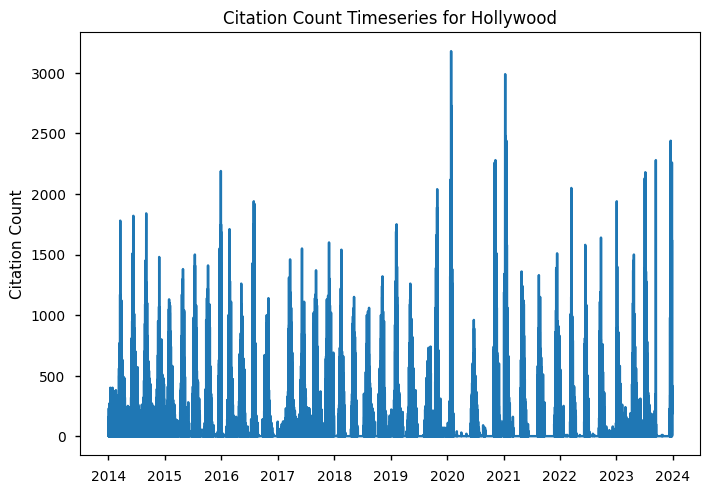

In [3]:
hollywood_citations = citations_ts.loc[citations_ts['district'] == 'Hollywood']
plt.figure()
plt.plot(hollywood_citations.index, hollywood_citations['citation_count'])
plt.title('Citation Count Timeseries for Hollywood')
plt.ylabel('Citation Count')
plt.show()

### Trivial Model

Let's split the training and test set and get a baseline model that predicts a constant citation count for all future timesteps. We'll use an ARIMA model with 0 autoregressive (AR) terms and 0 moving average (MA) filter terms to find the future citation count.

In [4]:
TRAIN_SPLIT = 0.8
split_index = int(hollywood_citations.shape[0] * TRAIN_SPLIT)
train_ts, test_ts = hollywood_citations.iloc[:split_index, 1], hollywood_citations.iloc[split_index:, 1]

In [5]:
X_train, y_train = train_ts.index, train_ts.values
X_test, y_test = test_ts.index, test_ts.values

In [6]:
arima = ARIMA(train_ts, order=(0, 0, 0), enforce_invertibility=False, enforce_stationarity=False)
results = arima.fit()
results.summary()

/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/Users/evan-datum/Documents/Personal/Data Science/Projects/strategic-parking-enforcement/venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         citation_count   No. Observations:                70029
Model:                          ARIMA   Log Likelihood             -451070.046
Date:                Mon, 12 Aug 2024   AIC                         902144.092
Time:                        14:49:00   BIC                         902162.405
Sample:                    01-01-2014   HQIC                        902149.740
                         - 12-27-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.1112      0.929     64.739      0.000      58.291      61.931
sigma2      2.302e+04     42.325    543.932      0.000    2.29e+04    2.31e+04
===================================================================================
Ljung-Box (L1) (Q):               31328.10   Jarque-Bera (JB):           5536720.76
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             5.23
Prob(H) (two-sided):                  0.61   Kurtosis:                        45.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

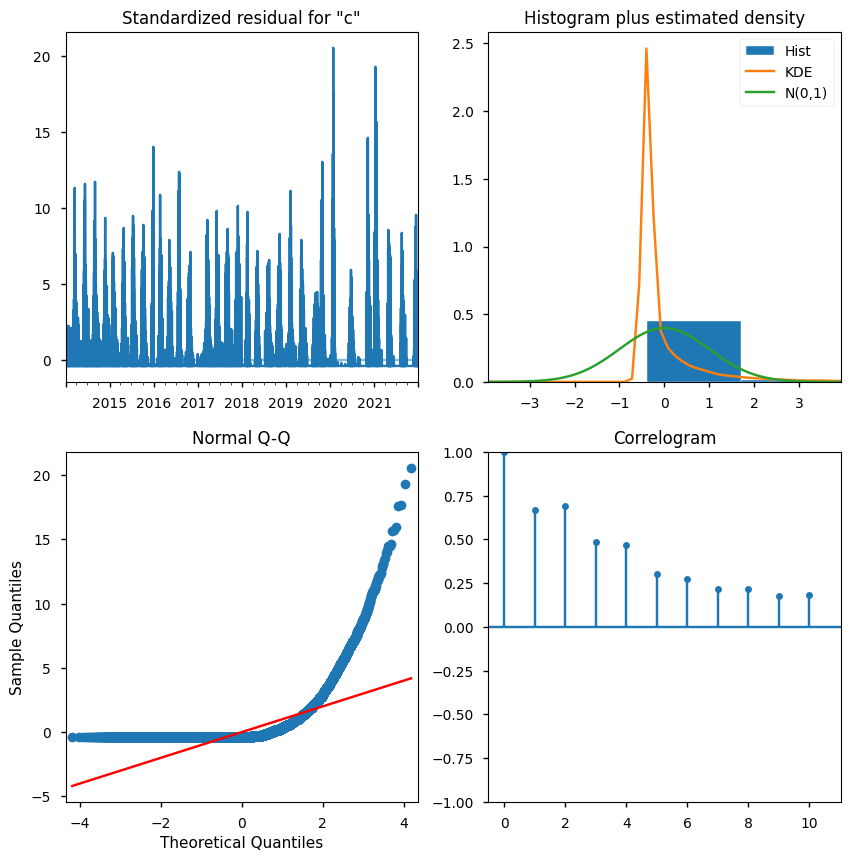

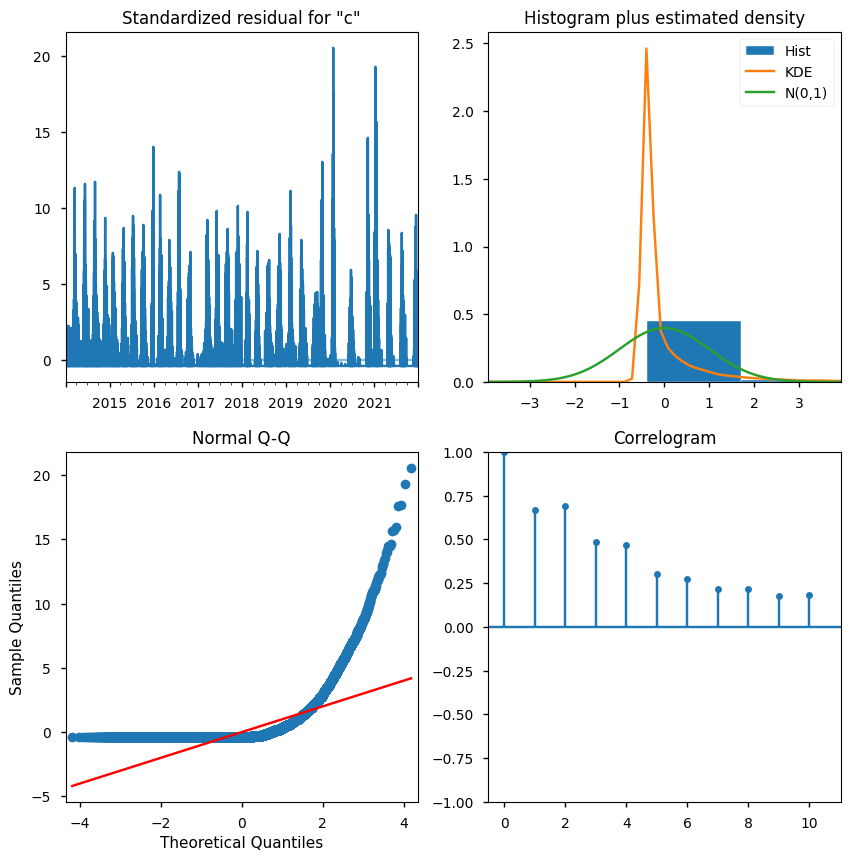

In [7]:
results.plot_diagnostics(figsize=(10,10))

In [66]:
# Plot the trivial model

In [67]:
# Print RSME and ACF plots

#### SARIMA Model
Capturing seasonality is important, we'll use a 24 hour period to try and pick up any daily seasonality. In order to isolate the best parameters, we'll run a grid search across autoregressive, differencing and moving average terms

In [ ]:
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

np.random.seed(2024)

p = d = q = range(3)
pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 24) for x in pdq]
count = 1

models = []
for comb in pdq:
    for combs in pdqs:
        try:
            sarima = SARIMAX(train_ts, order=comb, seasonal_order=combs, enforce_invertibility=False, enforce_stationarity=False)
            model = sarima.fit()
            sarima.fit()

            models.append([comb, combs, model.aic])
            count += 1
        except:
            continue

models_df = pd.DataFrame(models, columns=['pdq', 'pdqs', 'aic'])
models_df.sort_values('aic').head(20)

In [ ]:
best_sarima = SARIMAX(train_ts, order=(), seasonal_order=(), enforce_invertibility=False, enforce_stationarity=False)
results = best_sarima.fit()
results.summary()

In [ ]:
results.plot_diagnostics(figsize=(10,10))

In [ ]:
# Plot SARIMA predictions